In [73]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [74]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# General Exploration and Cleaning

In [75]:
df.head(2)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [77]:
df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [78]:
#checking for missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending = False)
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_values.head(20)

,Total,Percent
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
fireplacequ,690,47.260274
lotfrontage,259,17.739726
garagecond,81,5.547945
garagetype,81,5.547945
garageyrblt,81,5.547945
garagefinish,81,5.547945


In [79]:
percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending = False)
for i in percent:
    if i > 40:
        print(i)

99.52054794520548
96.3013698630137
93.76712328767124
80.75342465753425
47.26027397260274


We can observe that the top 5 variables in the table are missing more than 40% of datapoints. Since these features don't appear to be the top qualities of what people may prioritize when purchasing a house, we will delete these columns:
PoolQC
MiscFeature
Alley
Fence
FireplaceQu

In [80]:
df = df.drop(['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ'], axis=1)

In [81]:
df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'garagetype', 'garageyrblt', 'garagefinish',
       'garagecars', 'garagearea', 'garagequal', 'garagecond', 'paveddrive',
       'wooddecksf', 'o

The rest missing values we will fill with the mean.

In [82]:
df.fillna(df.mean(), inplace=True)


In [83]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [84]:
(df.isnull().sum()*100/df.isnull().count()).sort_values(ascending = False)

garagequal       5.547945
garagetype       5.547945
garagefinish     5.547945
garagecond       5.547945
bsmtexposure     2.602740
bsmtfintype2     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrtype       0.547945
electrical       0.068493
roofstyle        0.000000
roofmatl         0.000000
exterior1st      0.000000
saleprice        0.000000
exterior2nd      0.000000
yearbuilt        0.000000
masvnrarea       0.000000
exterqual        0.000000
extercond        0.000000
foundation       0.000000
yearremodadd     0.000000
housestyle       0.000000
overallcond      0.000000
landcontour      0.000000
mssubclass       0.000000
mszoning         0.000000
lotfrontage      0.000000
lotarea          0.000000
street           0.000000
                   ...   
paveddrive       0.000000
wooddecksf       0.000000
openporchsf      0.000000
threessnporch    0.000000
functional       0.000000
screenporch      0.000000
poolarea         0.000000
miscval     

I see some of the columns aren't filled because they are "object". I'm going to fill them separately with "mode"

In [85]:
object_list = ['garagetype', 'garagefinish', 'garagequal', 'garagecond', 'bsmtfintype2', 'bsmtexposure', 
               'bsmtfintype1', 'bsmtcond', 'bsmtqual', 'masvnrtype', 'electrical']

In [86]:
for i in object_list:
    # Imputation by mode

    df = df.fillna(df.mode().iloc[0])
    #df.fillna(df.mode(), inplace=True)

In [87]:
(df.isnull().sum()*100/df.isnull().count()).sort_values(ascending = False)

saleprice        0.0
extercond        0.0
roofstyle        0.0
roofmatl         0.0
exterior1st      0.0
exterior2nd      0.0
masvnrtype       0.0
masvnrarea       0.0
exterqual        0.0
foundation       0.0
salecondition    0.0
bsmtqual         0.0
bsmtcond         0.0
bsmtexposure     0.0
bsmtfintype1     0.0
bsmtfinsf1       0.0
bsmtfintype2     0.0
bsmtfinsf2       0.0
yearremodadd     0.0
yearbuilt        0.0
overallcond      0.0
overallqual      0.0
mssubclass       0.0
mszoning         0.0
lotfrontage      0.0
lotarea          0.0
street           0.0
lotshape         0.0
landcontour      0.0
utilities        0.0
                ... 
wooddecksf       0.0
openporchsf      0.0
enclosedporch    0.0
threessnporch    0.0
screenporch      0.0
poolarea         0.0
miscval          0.0
mosold           0.0
yrsold           0.0
saletype         0.0
garagefinish     0.0
garagetype       0.0
heatingqc        0.0
fireplaces       0.0
centralair       0.0
electrical       0.0
firstflrsf   

## Split Data into Categorical and Continuous Sets

In [88]:
# Create List of Non-Numeric/Categorical Columns
categorical_columns = df.select_dtypes(['object']).columns
print(categorical_columns)
print(f"The number of categorical columns is {len(categorical_columns)}")

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'saletype', 'salecondition'],
      dtype='object')
The number of categorical columns is 38


In [89]:
# Create List of Numeric Columns
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print(f"The number of numerical columns is {len(numeric_columns)}")

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


# Exploratory data analysis and feature selection

Target - 'saleprice'

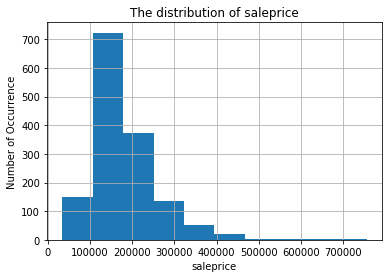

In [90]:
df.saleprice.hist()
plt.title("The distribution of saleprice")
plt.xlabel("saleprice")
plt.ylabel("Number of Occurrence")
plt.show()

In [91]:
df['saleprice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

### Target vs Numeric Features

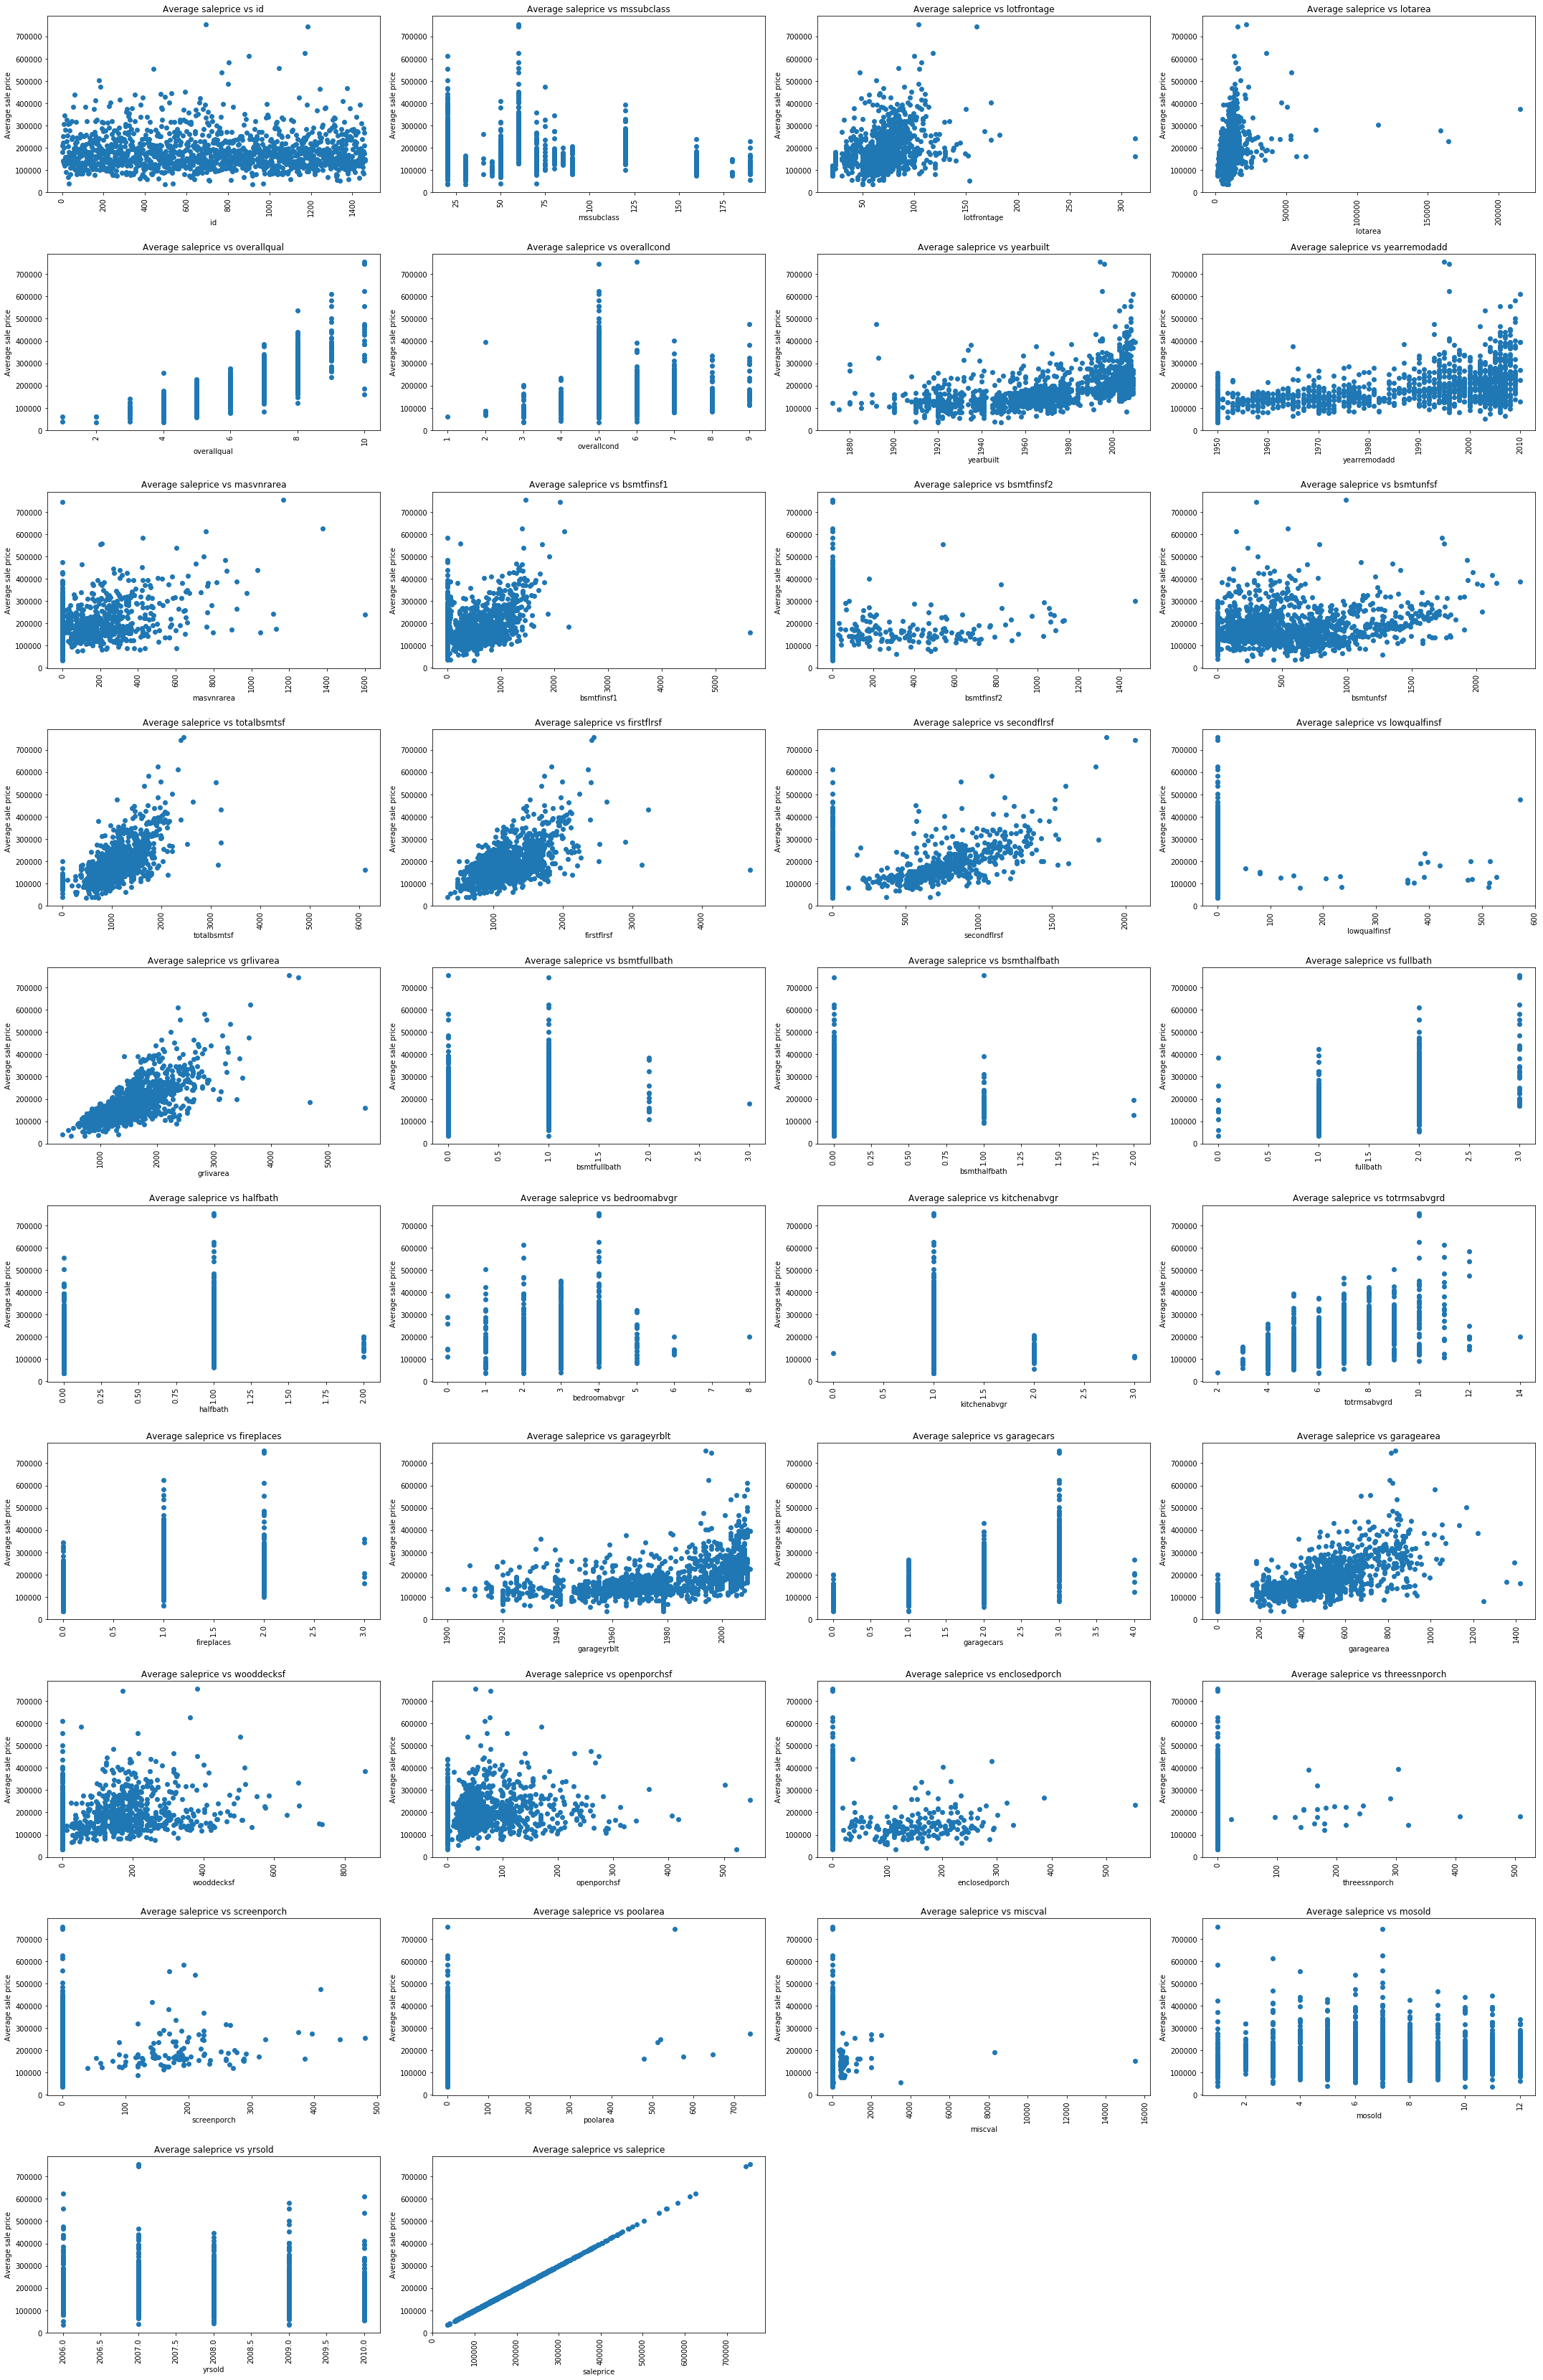

In [92]:
plt.figure(figsize=(30,50))

for i, column in enumerate(numeric_columns):
    plt.subplot(11,4,i+1)
    plt.scatter(df[column],df['saleprice'])
    plt.title(f"Average saleprice vs {column}")
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [93]:
df[numeric_columns].corr().loc[:,"saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.475241
garageyrblt      0.470177
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.334901
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

The top correlated variables to sale price (I am concidering more than 50% correlation):
    
   **overallqual**      0.790982 - Rates the overall material and finish of the house

        10   Very Excellent
        9    Excellent
        8    Very Good
        7    Good
        6    Above Average
        5    Average
        4    Below Average
        3    Fair
        2    Poor
        1    Very Poor
- **grlivarea**        0.708624 - Above grade (ground) living area square feet
- **garagecars**       0.640409 - Size of garage in car capacity
- **garagearea**       0.623431 - Size of garage in square feet
- **totalbsmtsf**      0.613581 - Total square feet of basement area
- **firstflrsf**       0.605852 - First Floor square feet
- **fullbath**         0.560664 - Full bathrooms above grade
- **totrmsabvgrd**     0.533723 - Total rooms above grade (does not include bathrooms)
- **yearbuilt**        0.522897 - Original construction date
- **yearremodadd**     0.507101 - Remodel date (same as construction date if no remodeling or additions)

We cann assume what potentional buyers would be interested in searching for a new house.

### Target vs categorical Features

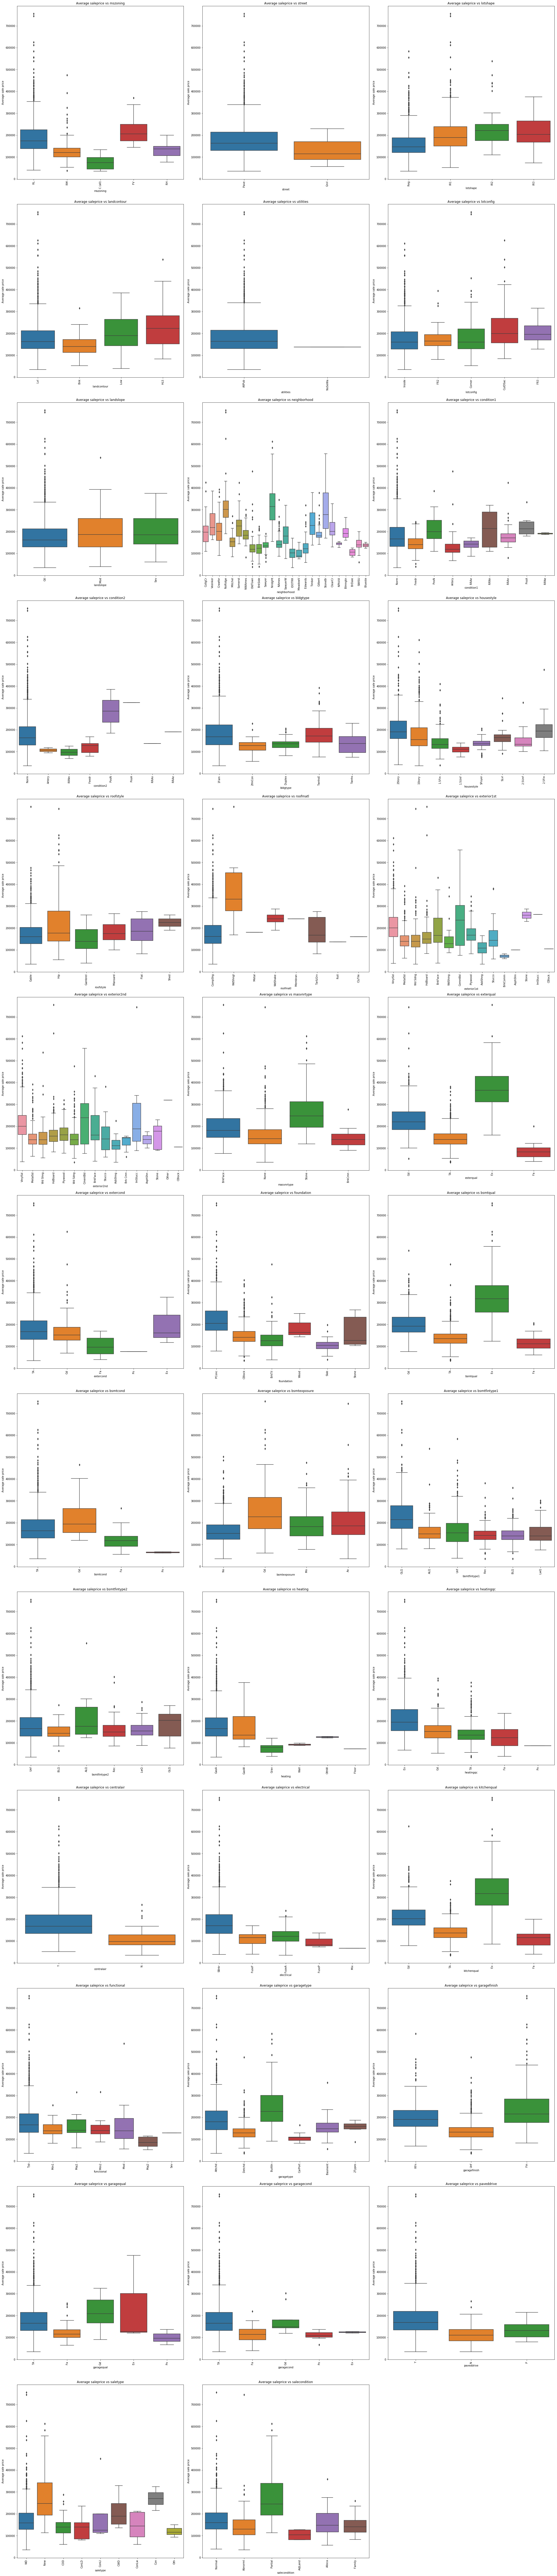

In [94]:
import seaborn as sns
plt.figure(figsize=(30,350))

for i, column in enumerate(categorical_columns):
    plt.subplot(33,3,i+1)
    sns.boxplot(df[column],df['saleprice'])
    plt.title(f"Average saleprice vs {column}")
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

### Outliers

Now Let's try the "Tukey's method" to see how many outliers we have.

In [95]:
numeric_list = ['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd']

In [96]:
for col in numeric_list:
    q75, q25 = np.percentile(df[col], [75 ,25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("Number of outliers for {} is: {} and it is {} percent.".format(col, len((np.where((df[col] > max_val) 
                      | (df[col] < min_val))[0])), len((np.where((df[col] > max_val) | 
                                                    (df[col] < min_val))[0]))*100/1460))

Number of outliers for overallqual is: 2 and it is 0.136986301369863 percent.
Number of outliers for grlivarea is: 31 and it is 2.1232876712328768 percent.
Number of outliers for garagecars is: 5 and it is 0.3424657534246575 percent.
Number of outliers for garagearea is: 21 and it is 1.4383561643835616 percent.
Number of outliers for totalbsmtsf is: 61 and it is 4.178082191780822 percent.
Number of outliers for firstflrsf is: 20 and it is 1.36986301369863 percent.
Number of outliers for fullbath is: 0 and it is 0.0 percent.
Number of outliers for totrmsabvgrd is: 30 and it is 2.0547945205479454 percent.
Number of outliers for yearbuilt is: 7 and it is 0.4794520547945205 percent.
Number of outliers for yearremodadd is: 0 and it is 0.0 percent.


Text(0.5, 1.0, 'overallqual_winsorized')

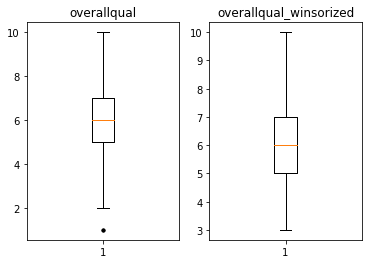

In [97]:
from scipy.stats.mstats import winsorize

plt.subplot(1,2,1)
plt.boxplot(df["overallqual"], sym='k.')
plt.title("overallqual")

overallqual_winsorized = winsorize(df["overallqual"], (0.007, 0))
plt.subplot (1,2,2)
plt.boxplot(overallqual_winsorized)
plt.title("overallqual_winsorized")

Text(0.5, 1.0, 'grlivarea_winsorized')

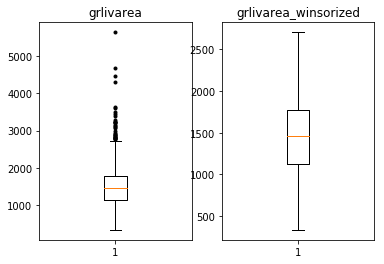

In [98]:
plt.subplot(1,2,1)
plt.boxplot(df["grlivarea"], sym='k.')
plt.title("grlivarea")

grlivarea_winsorized = winsorize(df["grlivarea"], (0, 0.025))
plt.subplot (1,2,2)
plt.boxplot(grlivarea_winsorized)
plt.title("grlivarea_winsorized")

Text(0.5, 1.0, 'garagecars_winsorized')

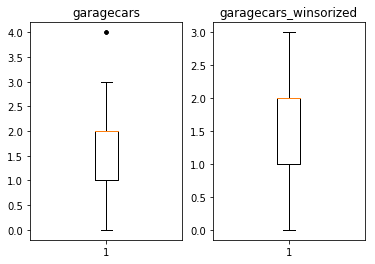

In [99]:
plt.subplot(1,2,1)
plt.boxplot(df["garagecars"], sym='k.')
plt.title("garagecars")

garagecars_winsorized = winsorize(df["garagecars"], (0, 0.01))
plt.subplot (1,2,2)
plt.boxplot(garagecars_winsorized)
plt.title("garagecars_winsorized")

Text(0.5, 1.0, 'garagearea_winsorized')

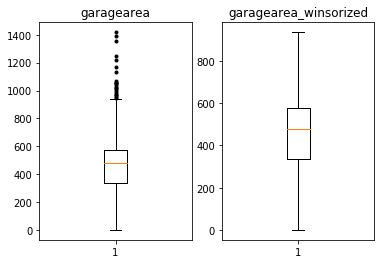

In [100]:
plt.subplot(1,2,1)
plt.boxplot(df["garagearea"], sym='k.')
plt.title("garagearea")

garagearea_winsorized = winsorize(df["garagearea"], (0, 0.015))
plt.subplot (1,2,2)
plt.boxplot(garagearea_winsorized)
plt.title("garagearea_winsorized")

Text(0.5, 1.0, 'totalbsmtsf_winsorized')

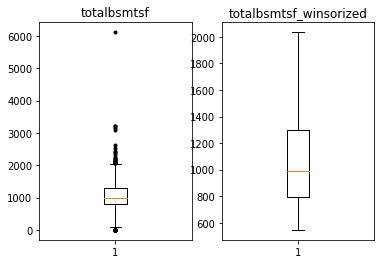

In [101]:
plt.subplot(1,2,1)
plt.boxplot(df["totalbsmtsf"], sym='k.')
plt.title("totalbsmtsf")

totalbsmtsf_winsorized = winsorize(df["totalbsmtsf"], (0.06, 0.018))
plt.subplot (1,2,2)
plt.boxplot(totalbsmtsf_winsorized)
plt.title("totalbsmtsf_winsorized")

Text(0.5, 1.0, 'firstflrsf_winsorized')

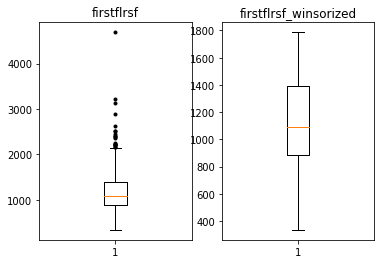

In [102]:
plt.subplot(1,2,1)
plt.boxplot(df["firstflrsf"], sym='k.')
plt.title("firstflrsf")

firstflrsf_winsorized = winsorize(df["firstflrsf"], (0, 0.06))
plt.subplot (1,2,2)
plt.boxplot(firstflrsf_winsorized)
plt.title("firstflrsf_winsorized")

Text(0.5, 1.0, 'fullbath_winsorized')

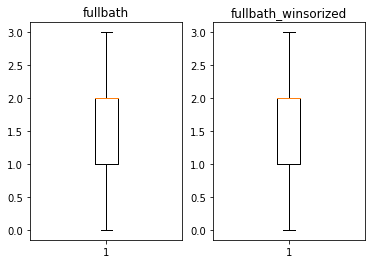

In [103]:
plt.subplot(1,2,1)
plt.boxplot(df["fullbath"], sym='k.')
plt.title("fullbath")

fullbath_winsorized = winsorize(df["fullbath"], (0, 0))
plt.subplot (1,2,2)
plt.boxplot(fullbath_winsorized)
plt.title("fullbath_winsorized")

Text(0.5, 1.0, 'totrmsabvgrd_winsorized')

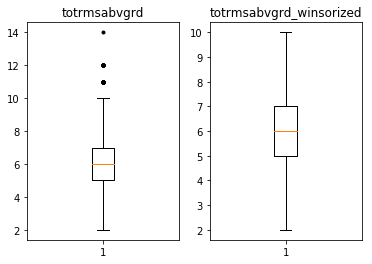

In [104]:
plt.subplot(1,2,1)
plt.boxplot(df["totrmsabvgrd"], sym='k.')
plt.title("totrmsabvgrd")

totrmsabvgrd_winsorized = winsorize(df["totrmsabvgrd"], (0, 0.021))
plt.subplot (1,2,2)
plt.boxplot(totrmsabvgrd_winsorized)
plt.title("totrmsabvgrd_winsorized")

Text(0.5, 1.0, 'yearbuilt_winsorized')

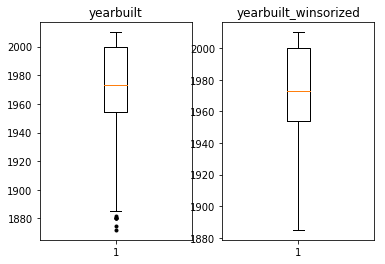

In [105]:
plt.subplot(1,2,1)
plt.boxplot(df["yearbuilt"], sym='k.')
plt.title("yearbuilt")

yearbuilt_winsorized = winsorize(df["yearbuilt"], (0.006, 0))
plt.subplot (1,2,2)
plt.boxplot(yearbuilt_winsorized)
plt.title("yearbuilt_winsorized")

Text(0.5, 1.0, 'yearremodadd_winsorized')

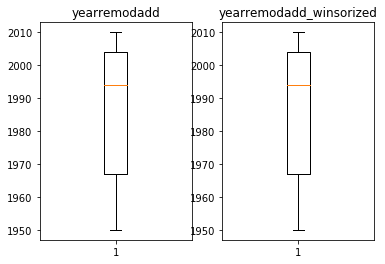

In [106]:
plt.subplot(1,2,1)
plt.boxplot(df["yearremodadd"], sym='k.')
plt.title("yearremodadd")

yearremodadd_winsorized = winsorize(df["yearremodadd"], (0, 0))
plt.subplot (1,2,2)
plt.boxplot(yearremodadd_winsorized)
plt.title("yearremodadd_winsorized")

In [107]:
df2 = df.copy()
# Add winsorized variable to the dataframe 
df2['overallqual_winsorized'] = overallqual_winsorized
df2['grlivarea_winsorized'] = grlivarea_winsorized
df2['garagecars_winsorized'] = garagecars_winsorized
df2['garagearea_winsorized'] = garagearea_winsorized
df2['totalbsmtsf_winsorized'] = totalbsmtsf_winsorized
df2['firstflrsf_winsorized'] = firstflrsf_winsorized
df2['fullbath_winsorized'] = fullbath_winsorized
df2['totrmsabvgrd_winsorized'] = totrmsabvgrd_winsorized
df2['yearbuilt_winsorized'] = yearbuilt_winsorized
df2['yearremodadd_winsorized'] = yearremodadd_winsorized

 # Explore the data using univariate and multivariate exploration techniques.

### We'll start with vcontinuous variables

In [108]:
df_w = df2[['saleprice', 'overallqual_winsorized', 'grlivarea_winsorized', 'garagecars_winsorized', 'garagearea_winsorized',
'totalbsmtsf_winsorized', 'firstflrsf_winsorized', 'fullbath_winsorized', 'totrmsabvgrd_winsorized', 'yearbuilt_winsorized',
'yearremodadd_winsorized']].copy()

In [109]:
df[['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'garagearea',
'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt',
'yearremodadd']].describe()

,saleprice,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,fullbath,totrmsabvgrd,yearbuilt,yearremodadd
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,6.099315,1515.463699,1.767123,472.980137,1057.429452,1162.626712,1.565068,6.517808,1971.267808,1984.865753
std,79442.502883,1.382997,525.480383,0.747315,213.804841,438.705324,386.587738,0.550916,1.625393,30.202904,20.645407
min,34900.000000,1.000000,334.000000,0.000000,0.000000,0.000000,334.000000,0.000000,2.000000,1872.000000,1950.000000
25%,129975.000000,5.000000,1129.500000,1.000000,334.500000,795.750000,882.000000,1.000000,5.000000,1954.000000,1967.000000
50%,163000.000000,6.000000,1464.000000,2.000000,480.000000,991.500000,1087.000000,2.000000,6.000000,1973.000000,1994.000000
75%,214000.000000,7.000000,1776.750000,2.000000,576.000000,1298.250000,1391.250000,2.000000,7.000000,2000.000000,2004.000000
max,755000.000000,10.000000,5642.000000,4.000000,1418.000000,6110.000000,4692.000000,3.000000,14.000000,2010.000000,2010.000000


In [110]:
df_w.describe()

,saleprice,overallqual_winsorized,grlivarea_winsorized,garagecars_winsorized,garagearea_winsorized,totalbsmtsf_winsorized,firstflrsf_winsorized,fullbath_winsorized,totrmsabvgrd_winsorized,yearbuilt_winsorized,yearremodadd_winsorized
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,6.104110,1502.745890,1.763699,470.638356,1066.543151,1145.140411,1.565068,6.487671,1971.299315,1984.865753
std,79442.502883,1.369444,478.854488,0.739318,207.032774,365.456820,336.067250,0.550916,1.541916,30.108397,20.645407
min,34900.000000,3.000000,334.000000,0.000000,0.000000,546.000000,334.000000,0.000000,2.000000,1885.000000,1950.000000
25%,129975.000000,5.000000,1129.500000,1.000000,334.500000,795.750000,882.000000,1.000000,5.000000,1954.000000,1967.000000
50%,163000.000000,6.000000,1464.000000,2.000000,480.000000,991.500000,1087.000000,2.000000,6.000000,1973.000000,1994.000000
75%,214000.000000,7.000000,1776.750000,2.000000,576.000000,1298.250000,1391.250000,2.000000,7.000000,2000.000000,2004.000000
max,755000.000000,10.000000,2704.000000,3.000000,936.000000,2035.000000,1787.000000,3.000000,10.000000,2010.000000,2010.000000


I can see the mean values haven't changed a lot. 

In [111]:
features = ['saleprice', 'overallqual_winsorized', 'grlivarea_winsorized', 'garagecars_winsorized', 'garagearea_winsorized',
'totalbsmtsf_winsorized', 'firstflrsf_winsorized', 'fullbath_winsorized', 'totrmsabvgrd_winsorized', 'yearbuilt_winsorized',
'yearremodadd_winsorized']

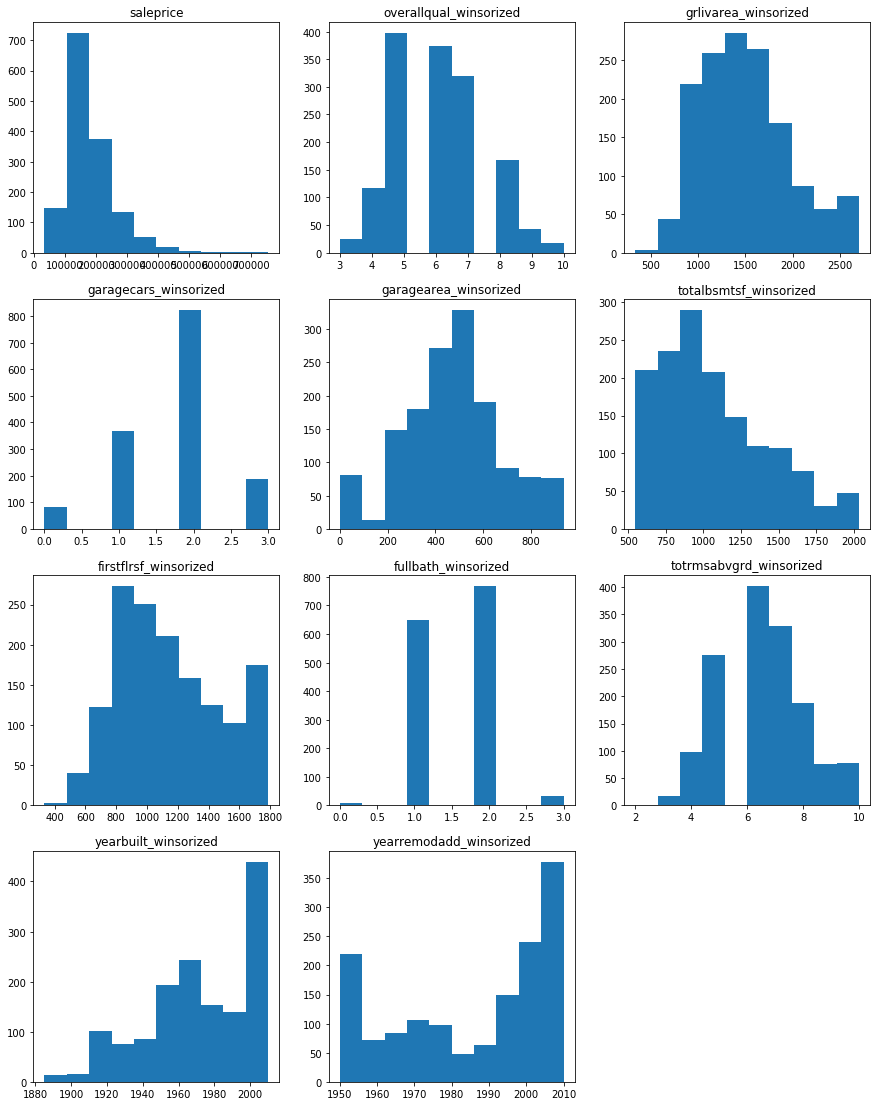

In [112]:
# Plot variables 

plt.figure(figsize=(15,50))

for i in range(len(features)):
    plt.subplot(10,3,i+1)
    plt.hist(df_w[features[i]])
    plt.title(features[i])

plt.show()

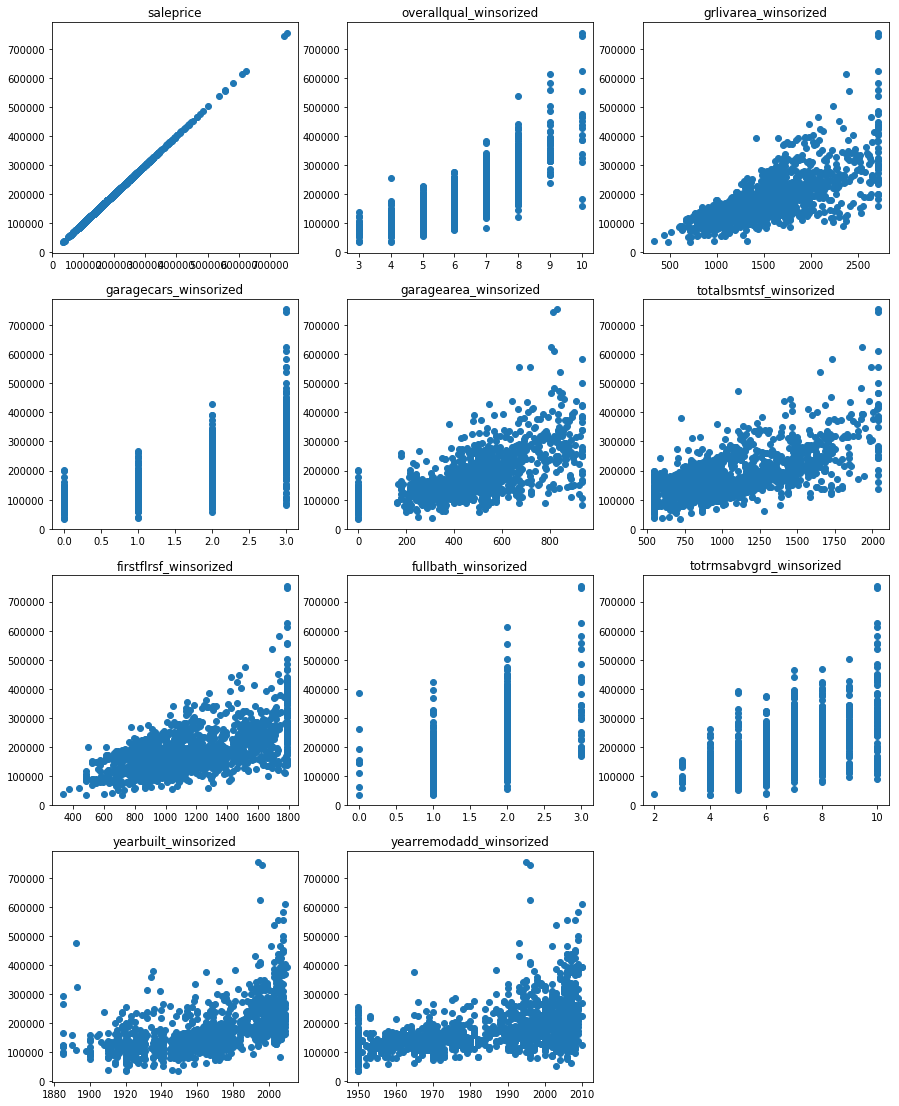

In [113]:
plt.figure(figsize=(15,50))

for i in range(len(features)):
    plt.subplot(10,3,i+1)
    plt.scatter(df_w[features[i]], y = df_w['saleprice'])
    plt.title(features[i])

plt.show()

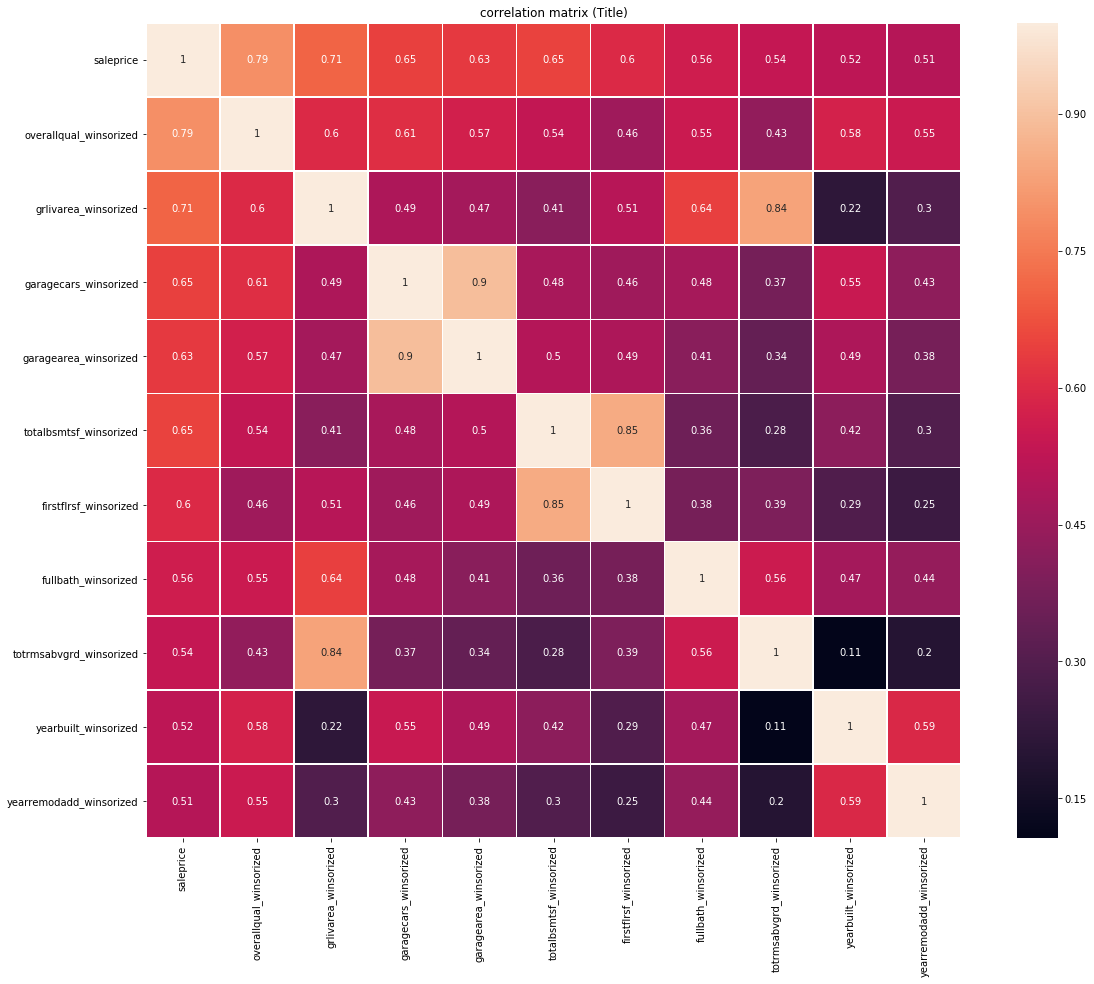

In [114]:
plt.figure(figsize=(20,15))
sns.heatmap(df_w[features].corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Title)")
plt.show()

some features corelated to each other so we can remove some of them:
1) grlivarea(Above grade (ground) living area square feet) and totrmsabvgrd (Total rooms above grade (does not include bathrooms))
2) garagecars (Size of garage in car capacity) and garagearea (Size of garage in square feet) 


In [115]:
del df_w['garagearea_winsorized']


In [116]:
list_boxplot = ['overallqual_winsorized','garagecars_winsorized', 'totalbsmtsf_winsorized','fullbath_winsorized', 'yearbuilt_winsorized']

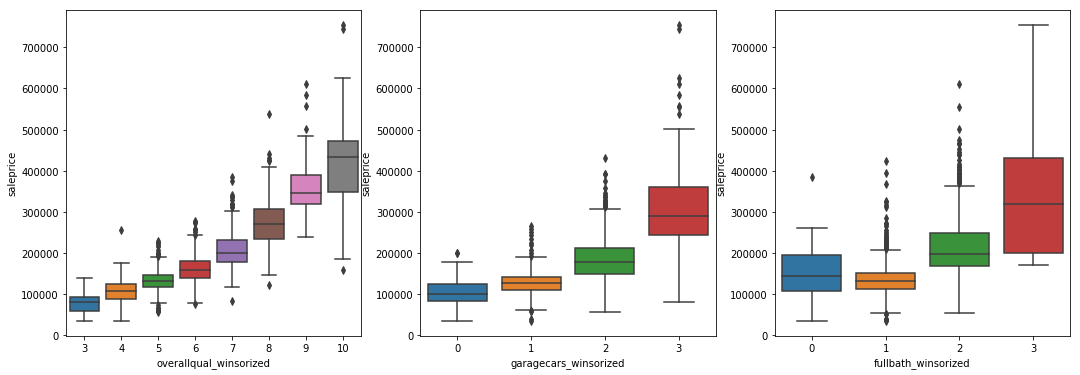

In [117]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
sns.boxplot(x='overallqual_winsorized', y="saleprice", data=df_w)
plt.subplot(1,3,2)
sns.boxplot(x='garagecars_winsorized', y="saleprice", data=df_w)
plt.subplot(1,3,3)
sns.boxplot(x='fullbath_winsorized', y="saleprice", data=df_w)

As expected, there is a positive association between overall quality, garagecers, fullbath and sale price. 

### Categorical Variables

Before plotting year built, we will create house age groups.

I will create a new DF just do not mess with my main one. 

In [118]:
df_cat = df2.copy()

In [119]:
cat_var = ['saleprice', 'mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'saletype', 'salecondition']

In [120]:
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
for i in cat_var:
    df_cat[i]= label_encoder.fit_transform(df_cat[i]) 


In [121]:
df_cat['salecondition'].unique() 


array([4, 0, 5, 1, 2, 3])

As we can see a lot of variable corelated to each other. I will chose those which shows the highest correlation with saleprice. 

In [122]:
df_cat[cat_var].corr().loc[:,"saleprice"].sort_values(ascending=False)

saleprice        1.000000
foundation       0.433460
centralair       0.298102
electrical       0.277364
paveddrive       0.268985
salecondition    0.236321
housestyle       0.225207
neighborhood     0.189857
roofstyle        0.169656
garagecond       0.160953
exterior2nd      0.137001
extercond        0.136942
garagequal       0.132290
exterior1st      0.131471
functional       0.129994
condition1       0.120881
roofmatl         0.101404
landslope        0.057289
bsmtcond         0.056280
street           0.043856
bsmtfintype2     0.031932
landcontour      0.023508
condition2       0.006860
masvnrtype      -0.014972
utilities       -0.017102
saletype        -0.034873
lotconfig       -0.069740
bldgtype        -0.076439
bsmtfintype1    -0.102407
heating         -0.120923
mszoning        -0.231544
bsmtexposure    -0.288000
lotshape        -0.295262
garagetype      -0.378316
heatingqc       -0.449409
kitchenqual     -0.555703
bsmtqual        -0.588858
garagefinish    -0.597372
exterqual   

In [123]:
cat_var_new = ['saleprice', 'foundation', 'centralair', 'electrical', 'paveddrive', 'roofstyle', 'salecondition', 'neighborhood']

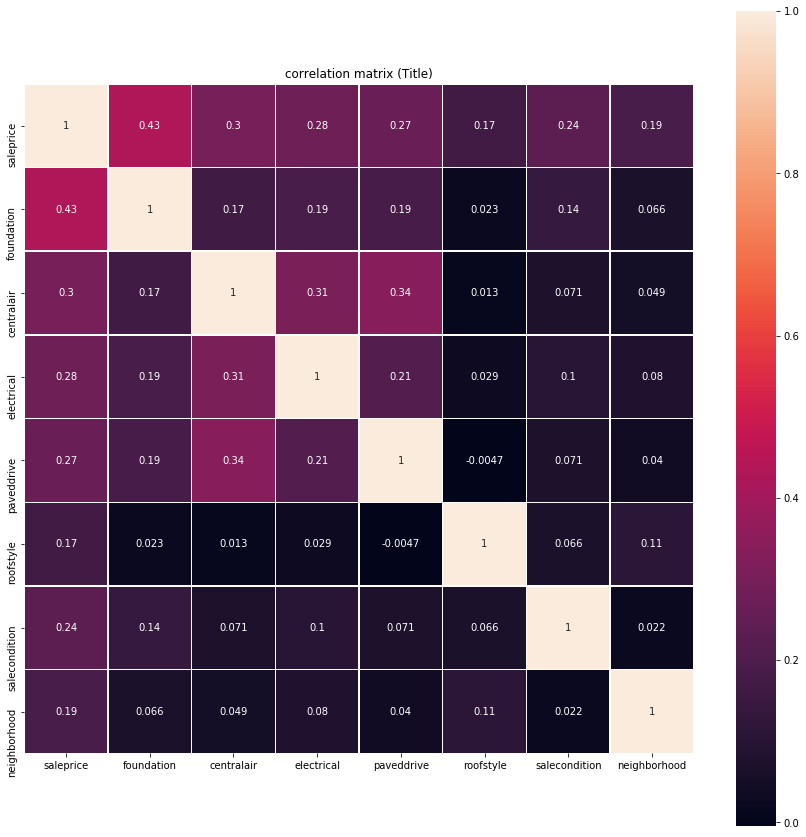

In [124]:
plt.figure(figsize=(15,15))
sns.heatmap(df_cat[cat_var_new].corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Title)")
plt.show()

Text(0.5, 1.0, 'Salecondition by Saleprice')

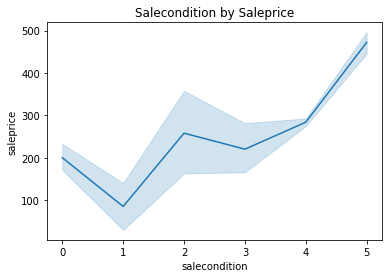

In [125]:

ax = sns.lineplot(x="salecondition", y="saleprice",data=df_cat)
plt.title('Salecondition by Saleprice')

I just pick 'salecondition', 'foundation' because they make sence. 


# Feature Engineering and Feature Selection

### Model 1

#### Numeric values
These are the features that are most correlated to sale price:
'overallqual_winsorized','garagecars_winsorized', 'totalbsmtsf_winsorized','fullbath_winsorized', 'yearbuilt_winsorized'

#### Categ Variables
We are going to use the following categorical variables to the model: 'salecondition', 'foundation'

In [126]:
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'country'. 
df2['salecondition']= label_encoder.fit_transform(df2['salecondition']) 
df2['foundation']= label_encoder.fit_transform(df2['foundation']) 
  


# Building a regression model (estimation the model using OLS)

## Run Regression

In [127]:
# Y is the target variable
Y = df2['saleprice']
# X is the feature set which includes
X = df2[['overallqual_winsorized','garagecars_winsorized', 'totalbsmtsf_winsorized','fullbath_winsorized', 'yearbuilt_winsorized', 'salecondition', 'foundation']]


In [128]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

The number of observations in training set is 1168
The number of observations in test set is 292


In [129]:
# Y is the target variable
Y = df2['saleprice']
# X is the feature set which includes
X = df2[['overallqual_winsorized','garagecars_winsorized', 'totalbsmtsf_winsorized','fullbath_winsorized', 'yearbuilt_winsorized', 'salecondition', 'foundation']]
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     576.7
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:57:21   Log-Likelihood:                -17573.
No. Observations:                1460   AIC:                         3.516e+04
Df Residuals:                    1452   BIC:                         3.520e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.616e+05   1.02e+05      1.577      0.115   -3.95e+04    3.63e+05
overallqual_winsorized  2.802e+04   1159.824     24.159      0.000    2.57e+04    3.03e+04
garagecars_winsorized    1.83e+04   1978.825      9.246      0.000    1.44e+04    2.22e+04
totalbsmtsf_winsorized    59.9816      3.603     16.650      0.000      52.915      67.048
fullbath_winsorized     1.702e+04   2438.284      6.979      0.000    1.22e+04    2.18e+04
yearbuilt_winsorized    -148.7805     54.211     -2.744      0.006    -255.120     -42.441
salecondition           3137.6728   1001.179      3.134      0.002    1173.760    5101.586
foundation              4939.7108   1947.495      2.536      0.011    1119.506    8759.916
==============================================================================
Omnibus:                      649.835   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10317.905
Skew:                           1.653   Prob(JB):                         0.00
Kurtosis:                      15.597   Cond. No.                     2.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the table above, we can see that the constant is insignifcant (not significant enough to be added). We will remove it.

### Model 2

In [130]:
# Y is the target variable
Y = df2['saleprice']
# X is the feature set which includes
X = df2[['overallqual_winsorized','garagecars_winsorized', 'totalbsmtsf_winsorized','fullbath_winsorized', 'yearbuilt_winsorized', 'salecondition', 'foundation']]

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     4641.
Date:                Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:57:21   Log-Likelihood:                -17575.
No. Observations:                1460   AIC:                         3.516e+04
Df Residuals:                    1453   BIC:                         3.520e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
overallqual_winsorized   2.77e+04   1142.797     24.241      0.000    2.55e+04    2.99e+04
garagecars_winsorized   1.769e+04   1941.472      9.109      0.000    1.39e+04    2.15e+04
totalbsmtsf_winsorized    59.2774      3.577     16.574      0.000      52.262      66.293
fullbath_winsorized     1.671e+04   2431.780      6.872      0.000    1.19e+04    2.15e+04
yearbuilt_winsorized     -63.4453      3.050    -20.801      0.000     -69.428     -57.462
salecondition           3067.7303   1000.707      3.066      0.002    1104.745    5030.716
foundation              3393.2336   1683.305      2.016      0.044      91.266    6695.201
==============================================================================
Omnibus:                      661.647   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10662.234
Skew:                           1.689   Prob(JB):                         0.00
Kurtosis:                      15.801   Cond. No.                     5.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Our R squared is 0.957
There isn't much difference between our R squared from the train set and the test set which means we are not overfitting!

This model is good enough.
Now let's see if it will be better to have other models such as lasso, ridge and elasticnet.

# Models to Evaluate

In [131]:
# Function to calculate mean absolute error

def mae(y_test, y_preds_test):
    return np.mean(abs(y_test - y_preds_test))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, Y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [132]:
# Y is the target variable
Y = df2['saleprice']
# X is the feature set which includes
X = df2[['overallqual_winsorized','garagecars_winsorized', 'totalbsmtsf_winsorized','fullbath_winsorized', 'yearbuilt_winsorized', 'salecondition', 'foundation']]


In [133]:
# Linear Regression

lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)


Linear Regression Performance on the test set: MAE = 28579.6772


# Ridge with CV

In [134]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.739723413720717
-----Test set statistics-----
R-squared of the model in test set is: 0.7185039474229356
Mean absolute error of the prediction is: 28674.931132146576
Mean squared error of the prediction is: 1889881196.429703
Root mean squared error of the prediction is: 43472.76384622564
Mean absolute percentage error of the prediction is: 16.680395374254886


# Lasso

In [135]:
lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_model.predict(X_train)
y_preds_test = lasso_model.predict(X_test)

print("Best alpha value is: {}".format(lasso_model.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_model.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_model.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 1e-10
R-squared of the model in training set is: 0.7397454174506071
-----Test set statistics-----
R-squared of the model in test set is: 0.718232934229073
Mean absolute error of the prediction is: 28735.078447643136
Mean squared error of the prediction is: 1891700698.814821
Root mean squared error of the prediction is: 43493.6857349986
Mean absolute percentage error of the prediction is: 16.732120649576


# ElasticNet

In [136]:
elasticNet_model = ElasticNetCV(alphas=alphas, cv=5) 
elasticNet_model.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticNet_model.predict(X_train)
y_preds_test = elasticNet_model.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticNet_model.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticNet_model.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7397377912051339
-----Test set statistics-----
R-squared of the model on the test set is: 0.7183963195624112
Mean absolute error of the prediction is: 28699.98535834385
Mean squared error of the prediction is: 1890603778.0359275
Root mean squared error of the prediction is: 43481.0737912017
Mean absolute percentage error of the prediction is: 16.701929091866777


#### Which model performed best?
Linear Regression has the highest R-qr.
Based on the MAE, Linear Regression had the least amount of error prediction so we will continue with using this model.

# Some useful factors that are not included in the dataset

In [140]:
# Import federal reserve dataset
interest = pd.read_csv('Desktop/Thinkful/interest_rates.csv', parse_dates=True)
idf = interest.copy()
idf.columns = idf.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

# Convert date variable to datetime type
idf['date'] = pd.to_datetime(idf.year*10000+idf.month*100+idf.day,format='%Y%m%d')
idf2 =idf.copy()
idf2.set_index('date',inplace=True)

# Fill in null values by interpolate since the dataset is a timeseries
idf2 = idf2.interpolate(method='time')

In [142]:
# Group by year to generate mean values 
features = idf2.loc[:,['year','effective_federal_funds_rate','unemployment_rate']]
by_year = features.groupby('year')

eco_feat= by_year.mean()

Now, that we have the dataset for economic features cleaned, we will merge it with the house price dataset on year sold. Before we can do that, we will rename the year column in the interest rate dataset to match year sold. To make merging easier, we will also convert both data types to integer.

In [143]:
# Create yrsold column
eco_feat['yrsold'] = eco_feat.index

# Match dtype for yrsold in both datasets
df2['yrsold'] = df['yrsold'].astype('int')
df2 = pd.merge(df2, eco_feat)

df2.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,garagecars_winsorized,garagearea_winsorized,totalbsmtsf_winsorized,firstflrsf_winsorized,fullbath_winsorized,totrmsabvgrd_winsorized,yearbuilt_winsorized,yearremodadd_winsorized,effective_federal_funds_rate,unemployment_rate
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,2,548,856,856,2,8,2003,2003,1.858998,5.82901
1,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,2,608,920,920,2,6,2001,2002,1.858998,5.82901
2,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,3,836,1145,1145,2,9,2000,2000,1.858998,5.82901
3,9,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,...,2,468,952,1022,2,8,1931,1950,1.858998,5.82901
4,10,190,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,...,1,205,991,1077,1,5,1939,1950,1.858998,5.82901


Alright. This looks good. Let's begin recreating the final model.

# Recreate Final Model
To recap, our feature variables include:

most correlated numeric variables (overall qualality, grade living area, garage cars, garage area)
log of sale price
dummy variables (neighborhoods, house age)
new variables (total basement area, total rooms abvove ground)
economic indicators (federal interest rates, unemployment rate)
We selected ridge regression as the best model to predict sale house prices since it had the smalled mean absolute error. Again, we will be using MAE to evaluate the models.

In [145]:
# Y is the target variable
Y = df2['saleprice']
# X is the feature set
X = df2[['overallqual_winsorized','garagecars_winsorized', 'totalbsmtsf_winsorized','fullbath_winsorized', 'yearbuilt_winsorized', 'salecondition', 'foundation','effective_federal_funds_rate','unemployment_rate']]


In [146]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


The number of observations in training set is 1168
The number of observations in test set is 292


In [149]:
# Ridge Regression 
lr = LinearRegression()
lr_mae2 = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae2)


Linear Regression Performance on the test set: MAE = 30805.9449


In [151]:

# Dataframe to hold the results
model_comparison = pd.DataFrame({'Model': ['Linear Regression', 'Linear Regression with Eco'],
                                 'MAE': [lr_mae, lr_mae2 ]})

# Horizontal bar chart of test mae
model_comparison.sort_values('MAE', ascending = True)

,Model,MAE
0,Linear Regression,28579.677226
1,Linear Regression with Eco,30805.944931


Based on the results, the MAE of the original features had a lower MAE, thus is a better fit model for predicting house prices.